## Import

In [1102]:
import sys
sys.path.append('..')


In [1103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import category_encoders as ce

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report


## 1. Data Analysis

In [1104]:
# display first 10 rows
df = pd.read_csv('../datasets/people/aw_fb_data.csv')

df.head(5)


,Unnamed: 0,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance,device,activity
0,1,1,20,1,168.0,65.4,10.771429,78.531302,0.344533,0.008327,6.221612,6.116349,59.0,1.000000,19.531302,0.138520,1.000000,0.089692,apple watch,Lying
1,2,2,20,1,168.0,65.4,11.475325,78.453390,3.287625,0.008896,6.221612,6.116349,59.0,1.000000,19.453390,0.137967,1.000000,0.102088,apple watch,Lying
2,3,3,20,1,168.0,65.4,12.179221,78.540825,9.484000,0.009466,6.221612,6.116349,59.0,1.000000,19.540825,0.138587,1.000000,0.115287,apple watch,Lying
3,4,4,20,1,168.0,65.4,12.883117,78.628260,10.154556,0.010035,6.221612,6.116349,59.0,1.000000,19.628260,0.139208,1.000000,0.129286,apple watch,Lying
4,5,5,20,1,168.0,65.4,13.587013,78.715695,10.825111,0.010605,6.221612,6.116349,59.0,0.982816,19.715695,0.139828,0.241567,0.144088,apple watch,Lying


In [1105]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6264 entries, 0 to 6263
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6264 non-null   int64  
 1   X1                    6264 non-null   int64  
 2   age                   6264 non-null   int64  
 3   gender                6264 non-null   int64  
 4   height                6264 non-null   float64
 5   weight                6264 non-null   float64
 6   steps                 6264 non-null   float64
 7   hear_rate             6264 non-null   float64
 8   calories              6264 non-null   float64
 9   distance              6264 non-null   float64
 10  entropy_heart         6264 non-null   float64
 11  entropy_setps         6264 non-null   float64
 12  resting_heart         6264 non-null   float64
 13  corr_heart_steps      6264 non-null   float64
 14  norm_heart            6264 non-null   float64
 15  intensity_karvonen   

In [1106]:
df.describe()


,Unnamed: 0,X1,age,gender,height,weight,steps,hear_rate,calories,distance,entropy_heart,entropy_setps,resting_heart,corr_heart_steps,norm_heart,intensity_karvonen,sd_norm_heart,steps_times_distance
count,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000,6264.000000
mean,3132.500000,1771.144317,29.158525,0.476533,169.709052,69.614464,109.562268,86.142331,19.471823,13.832555,6.030314,5.739984,65.869938,0.306447,20.272393,0.155479,8.110854,590.035239
std,1808.405375,1097.988748,8.908978,0.499489,10.324698,13.451878,222.797908,28.648385,27.309765,45.941437,0.765574,1.256348,21.203017,0.775418,28.388116,0.210927,12.535080,4063.838530
min,1.000000,1.000000,18.000000,0.000000,143.000000,43.000000,1.000000,2.222222,0.056269,0.000440,0.000000,0.000000,3.000000,-1.000000,-76.000000,-2.714286,0.000000,0.000690
25%,1566.750000,789.750000,23.000000,0.000000,160.000000,60.000000,5.159534,75.598079,0.735875,0.019135,6.108524,5.909440,58.134333,-0.467303,1.148883,0.009819,0.264722,0.659260
50%,3132.500000,1720.000000,28.000000,0.000000,168.000000,68.000000,10.092029,77.267680,4.000000,0.181719,6.189825,6.157197,75.000000,0.665829,9.820254,0.079529,2.893503,13.368619
75%,4698.250000,2759.250000,33.000000,1.000000,180.000000,77.300000,105.847222,95.669118,20.500000,15.697188,6.247928,6.247928,76.138701,1.000000,27.077336,0.211868,9.679672,93.728562
max,6264.000000,3670.000000,56.000000,1.000000,191.000000,115.000000,1714.000000,194.333333,97.500000,335.000000,6.475733,6.475733,155.000000,1.000000,156.319444,1.297980,74.457929,51520.000000


In [1107]:
# display shape of the dataset
df.shape


(6264, 20)

The dataset contains 6264 rows and 20 columns.

In [1108]:
# unique value of "activity" column
df['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

According to result above, there are 7 differet activities.

In [1109]:
# count total number of each activity
df.activity.value_counts()


Lying             1379
Running 7 METs    1114
Running 5 METs    1002
Running 3 METs     950
Sitting            930
Self Pace walk     889
Name: activity, dtype: int64

In [1110]:
# display type of data
df.dtypes.value_counts()


float64    14
int64       4
object      2
dtype: int64

### Plot object type data

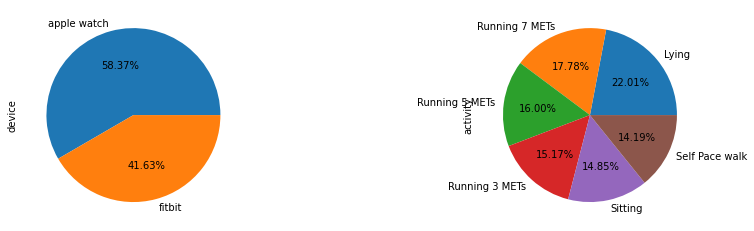

In [1111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
df['device'].value_counts().plot.pie(autopct='%.2f%%', ax=ax1)
df['activity'].value_counts().plot.pie(autopct='%.2f%%', ax=ax2)
plt.show()


### Plot activities of each device on heatmap

<AxesSubplot:xlabel='device', ylabel='activity'>

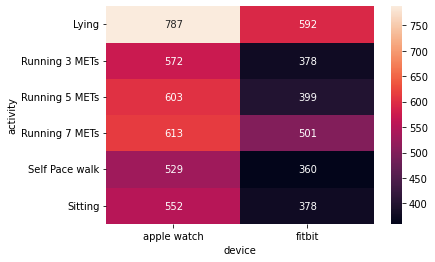

In [1112]:
sns.heatmap(pd.crosstab(df["activity"], df["device"]), annot=True, fmt='d')


## 2. Data Preprocessing

Prepare useful columns that will be used for building model

In [1113]:
df = df[["steps", "calories", "entropy_heart", "entropy_setps",
         "corr_heart_steps", "intensity_karvonen", "sd_norm_heart", "device", "activity"]]


In [1114]:
# display null value
df.isna().sum()


steps                 0
calories              0
entropy_heart         0
entropy_setps         0
corr_heart_steps      0
intensity_karvonen    0
sd_norm_heart         0
device                0
activity              0
dtype: int64

Plot columns on heatmap to see correlation

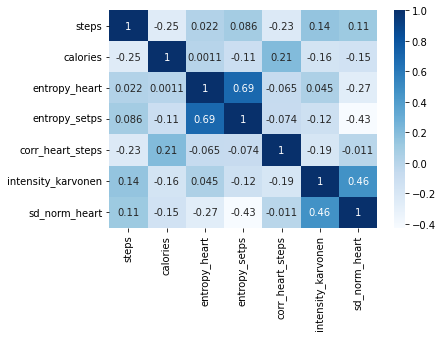

In [1115]:
ax = plt.subplots()
ax = sns.heatmap(df.corr(), annot=True, cmap="Blues")


<AxesSubplot:>

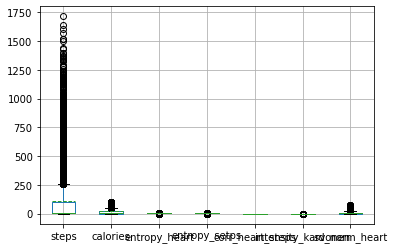

In [1116]:
df.boxplot(meanline=True, showmeans=True)


According to the boxplot above, we are able to know that the dataset contains outlier.

In [1117]:
# remove outlier using interquartile range (IQR)
def outlier(col):
    Q3, Q1 = np.nanpercentile(col, [75, 25])
    IQR = Q3 - Q1
    UL = Q3 + 1.5*IQR
    LL = Q1 - 1.5*IQR
    return UL, LL


In [1118]:
for column in df.columns:
    if df[column].dtype != 'object':
        UL, LL = outlier(df[column])
        df[column] = np.where((df[column] > UL) | (
            df[column] < LL), np.nan, df[column])


In [1119]:
# display null value
df.isna().sum()


steps                  814
calories              1149
entropy_heart          639
entropy_setps          641
corr_heart_steps         0
intensity_karvonen     520
sd_norm_heart          636
device                   0
activity                 0
dtype: int64

In [1120]:
# drop outlier
df.dropna()


,steps,calories,entropy_heart,entropy_setps,corr_heart_steps,intensity_karvonen,sd_norm_heart,device,activity
0,10.771429,0.344533,6.221612,6.116349,1.000000,0.138520,1.000000,apple watch,Lying
1,11.475325,3.287625,6.221612,6.116349,1.000000,0.137967,1.000000,apple watch,Lying
2,12.179221,9.484000,6.221612,6.116349,1.000000,0.138587,1.000000,apple watch,Lying
3,12.883117,10.154556,6.221612,6.116349,1.000000,0.139208,1.000000,apple watch,Lying
4,13.587013,10.825111,6.221612,6.116349,0.982816,0.139828,0.241567,apple watch,Lying
...,...,...,...,...,...,...,...,...,...
6185,2.223684,26.500000,6.339850,6.339850,1.000000,0.001021,0.066959,fitbit,Running 7 METs
6186,2.105263,28.000000,6.339850,6.339850,1.000000,0.000817,0.066959,fitbit,Running 7 METs
6187,1.986842,26.500000,6.339850,6.339850,1.000000,0.000613,0.066959,fitbit,Running 7 METs
6188,1.868421,26.500000,6.339850,6.339850,1.000000,0.000408,0.066959,fitbit,Running 7 METs


In [1121]:
# drop null value of X
df = df.dropna(axis=0)


In [1122]:
# split dataset based on device type (apple and fitbit)
df_apple = df.loc[df["device"] == "apple watch"]
df_fitbit = df.loc[df["device"] == "fitbit"]

# remove "device" column
df_apple = df_apple.drop("device", axis=1)
df_fitbit = df_fitbit.drop("device", axis=1)


## 3. Training

Split Apple & Fitbit data

In [1123]:
# df_apple = df.loc[df["device"] == "apple watch"]
# df_fitbit = df.loc[df["device"] == "fitbit"]


In [1124]:
# prepare data for training (apple)
X = df_apple.drop("activity", axis=1)
y = df_apple.loc[:, "activity"]


In [1125]:
# prepare data for training (fitbit)
X = df_fitbit.drop("activity", axis=1)
y = df_fitbit.loc[:, "activity"]


Feature encoding

In [1126]:
# display unique value of activity (apple)
df_apple['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

In [1127]:
# display unique value of activity (fitbit)
df_fitbit['activity'].unique()


array(['Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs'], dtype=object)

In [1128]:
# feature encoding
def one_hot_encoding(df):
    ordinal_encoder = ce.OrdinalEncoder(cols=['activity'],
                                        mapping=[
        {'col': 'activity', 'mapping': {
            'Lying': 0, 'Self Pace walk': 1, 'Running 3 METs': 2, 'Running 5 METs': 3, 'Sitting': 4, 'Running 7 METs': 5}},
    ])

    df_ = ordinal_encoder.fit_transform(df)
    return df_


In [1129]:
def preprocessing(df):
    df = one_hot_encoding(df)
    X = df.drop("activity", axis=1)
    y = df.loc[:, "activity"]
    # print(y.value_counts())
    return X, y


In [1130]:
# split 20% of data for testing
Apple_trainset, Apple_testset = train_test_split(
    df_apple, test_size=0.2, random_state=0)
fitbit_trainset, fitbit_testset = train_test_split(
    df_fitbit, test_size=0.2, random_state=0)


In [1131]:
XApple_train, yApple_train = preprocessing(Apple_trainset)
Xfitbit_train, yfitbit_train = preprocessing(fitbit_trainset)


In [1132]:
Xfitbit_test, yfitbit_test = preprocessing(fitbit_testset)
XApple_test, yApple_test = preprocessing(Apple_testset)


In [1133]:
# standardization the data
def standardisation(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df)
    return X


In [1134]:
XApple_train = standardisation(XApple_train)
Xfitbit_test = standardisation(Xfitbit_test)
XApple_test = standardisation(XApple_test)
Xfitbit_train = standardisation(Xfitbit_train)


## 4. Evaluation

In [1135]:
def evaluate_model(model, Xtrain, Ytrain, Xtest, Ytest):
    model.fit(Xtrain, Ytrain)
    ypred = model.predict(Xtest)
    print(classification_report(Ytest, ypred))
    print("Training accuracy {}".format(model.score(Xtrain, Ytrain)))
    print("Testing accuracy {}".format(model.score(Xtest, Ytest)))


### Decision Tree Model

In [1136]:
tree = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=13)


In [1137]:
print("Decision tree for apple watch")

evaluate_model(tree, XApple_train, yApple_train, XApple_test, yApple_test)


Decision tree for apple watch
              precision    recall  f1-score   support

           0       0.44      0.43      0.43        98
           1       0.42      0.47      0.45        72
           2       0.50      0.50      0.50       102
           3       0.61      0.57      0.59        94
           4       0.31      0.42      0.36        50
           5       0.50      0.29      0.37        41

    accuracy                           0.47       457
   macro avg       0.46      0.45      0.45       457
weighted avg       0.48      0.47      0.47       457

Training accuracy 0.9632876712328767
Testing accuracy 0.4682713347921225


In [1138]:
print("Decision tree for Fitbit")

evaluate_model(tree, Xfitbit_train, yfitbit_train, Xfitbit_test, yfitbit_test)


Decision tree for Fitbit
              precision    recall  f1-score   support

           0       0.85      0.65      0.74        84
           1       0.23      0.70      0.35        10
           2       0.31      0.45      0.37        11
           3       0.36      0.36      0.36        11
           4       0.75      0.46      0.57        46
           5       0.74      1.00      0.85        35

    accuracy                           0.64       197
   macro avg       0.54      0.60      0.54       197
weighted avg       0.72      0.64      0.66       197

Training accuracy 1.0
Testing accuracy 0.6446700507614214


### Support-vector machine model

In [1139]:
SVM = SVC()


In [1140]:
print("SVM for apple watch")

evaluate_model(SVM, XApple_train, yApple_train, XApple_test, yApple_test)


SVM for apple watch
              precision    recall  f1-score   support

           0       0.36      0.55      0.44        98
           1       0.57      0.38      0.45        72
           2       0.53      0.54      0.53       102
           3       0.62      0.64      0.63        94
           4       0.33      0.18      0.23        50
           5       0.62      0.49      0.55        41

    accuracy                           0.49       457
   macro avg       0.51      0.46      0.47       457
weighted avg       0.51      0.49      0.49       457

Training accuracy 0.5271232876712328
Testing accuracy 0.4923413566739606


In [1141]:
print("SVM for Fitbit")

evaluate_model(SVM, Xfitbit_train, yfitbit_train, Xfitbit_test, yfitbit_test)


SVM for Fitbit
              precision    recall  f1-score   support

           0       0.65      0.87      0.74        84
           1       0.23      0.30      0.26        10
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        11
           4       0.54      0.43      0.48        46
           5       0.79      0.77      0.78        35

    accuracy                           0.62       197
   macro avg       0.37      0.40      0.38       197
weighted avg       0.55      0.62      0.58       197

Training accuracy 0.6632653061224489
Testing accuracy 0.6243654822335025


/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### K-nearest Neighbors Classifier Model

In [1142]:
KNN = KNeighborsClassifier()


In [1143]:
print("KNN for Apple")

evaluate_model(KNN, XApple_train, yApple_train, XApple_test, yApple_test)


KNN for Apple
              precision    recall  f1-score   support

           0       0.61      0.66      0.63        98
           1       0.69      0.83      0.75        72
           2       0.76      0.65      0.70       102
           3       0.77      0.80      0.79        94
           4       0.61      0.46      0.52        50
           5       0.71      0.71      0.71        41

    accuracy                           0.70       457
   macro avg       0.69      0.68      0.68       457
weighted avg       0.70      0.70      0.69       457

Training accuracy 0.8345205479452055
Testing accuracy 0.6958424507658644


/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

In [1144]:
print("KNN for Fitbit")

evaluate_model(KNN, Xfitbit_train, yfitbit_train, Xfitbit_test, yfitbit_test)


/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

KNN for Fitbit
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        84
           1       0.38      0.60      0.46        10
           2       0.75      0.55      0.63        11
           3       0.67      0.55      0.60        11
           4       0.80      0.78      0.79        46
           5       0.80      0.91      0.85        35

    accuracy                           0.79       197
   macro avg       0.71      0.70      0.70       197
weighted avg       0.80      0.79      0.79       197

Training accuracy 0.8647959183673469
Testing accuracy 0.7868020304568528


/Users/vatanak/Library/Python/3.8/lib/python/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


### According to the 3 trained models above, KNN seems to perform better that Decision tree and Support-vector machine for both Apple and Fitbit. Thus, KNN will be used for our application.